In [9]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("data/ligand-qsar/alkylamine-ligand-modeling.tsv", sep="\t")
df = df[df["buchwald-type"] > 0]

# Define bins and labels
activity_cutoff = 15
bins = [-np.inf, activity_cutoff, np.inf]
labels = ["Low", "High"]
transformer = preprocessing.FunctionTransformer(pd.cut, kw_args={"bins": bins, "labels": labels, "retbins": False})

# Standardize features
features = ["min_partial_charge_phosphine", "max_buried_volume_3.5A", "max_P_int_ligand", "max_sasa_ligand_area"]

scaler = StandardScaler()
X = df.drop(columns=["ligand_1_name", "product_1_yield"])[features]
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Transform target
y = df["product_1_yield"]
y_bin = transformer.fit_transform(y)

In [3]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold


def evaluate_model(clf):
    """Evaluate a model using cross-validation."""
    clf.fit(X, y_bin)
    print(X.columns)
    preds = clf.predict(X)
    print(f"Accuracy: {metrics.accuracy_score(y_bin, preds):0.2f}")
    print(f"F1: {metrics.f1_score(y_bin, preds, pos_label='High'):0.2f}")
    print(f"MCC: {metrics.matthews_corrcoef(y_bin, preds):0.2f}")
    print("Confusion matrix:\n", metrics.confusion_matrix(y_bin, preds))
    print(f"Incorrect ligands: {df.loc[y_bin != preds, 'ligand_1_name'].tolist()}")
    print()

    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    kfold_accuracies = []
    kfold_high_yield_f1s = []
    kfold_mccs = []
    for train_index, test_index in kfold.split(X, y_bin):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_bin[train_index], y_bin[test_index]

        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        accuracy = metrics.accuracy_score(y_test, preds)
        high_yield_f1 = metrics.f1_score(y_test, preds, pos_label="High")
        mcc = metrics.matthews_corrcoef(y_test, preds)

        kfold_accuracies.append(accuracy)
        kfold_high_yield_f1s.append(high_yield_f1)
        kfold_mccs.append(mcc)

    print(f"K-Fold Accuracy: {np.mean(kfold_accuracies):0.2f} +/- {np.std(kfold_accuracies):0.2f}")
    print(f"K-Fold F1: {np.mean(kfold_high_yield_f1s):0.2f} +/- {np.std(kfold_high_yield_f1s):0.2f}")
    print(f"K-Fold MCC: {np.mean(kfold_mccs):0.2f} +/- {np.std(kfold_mccs):0.2f}")
    print()

In [4]:
from itertools import combinations

from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

run = True


def evaluate_combination(features: tuple):
    """Evaluate a combination of features."""
    clf = LogisticRegression(random_state=42, class_weight="balanced", C=6)
    clf.fit(X[list(features)], y_bin)
    f1 = round(metrics.f1_score(y_bin, clf.predict(X[list(features)]), pos_label="High"), 2)
    if f1 < 0.7:
        return (features, f1, 0)
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    kfold_f1s = []
    for train_index, test_index in kfold.split(X, y_bin):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_bin[train_index], y_bin[test_index]
        clf.fit(X_train[list(features)], y_train)
        preds = clf.predict(X_test[list(features)])
        f1_k = metrics.f1_score(y_test, preds, pos_label="High")
        kfold_f1s.append(f1_k)
    kfold_f1 = round(np.mean(kfold_f1s), 2)
    return (features, f1, kfold_f1)


combinations_list = (
    list(combinations(X.columns, 2)) + list(combinations(X.columns, 3)) + list(combinations(X.columns, 4))
)
print(f"Number of combinations: {len(combinations_list)}")

if run:
    results = Parallel(n_jobs=-1)(delayed(evaluate_combination)(features) for features in tqdm(combinations_list))

    results = sorted(results, key=lambda x: x[1], reverse=True)
    for features, f1, kfold_f1 in results[:10]:
        print(f"Features: {features}, F1: {f1}, K-Fold F1: {kfold_f1}")

Number of combinations: 246


  0%|          | 0/246 [00:00<?, ?it/s]

100%|██████████| 246/246 [00:15<00:00, 15.53it/s]


Features: ('min_partial_charge_phosphine', 'max_buried_volume_3.5A', 'max_P_int_ligand', 'max_sasa_ligand_area'), F1: 0.93, K-Fold F1: 0.95
Features: ('buried_volume_2.0A', 'min_partial_charge_phosphine', 'max_P_int_ligand', 'max_sasa_ligand_area'), F1: 0.88, K-Fold F1: 0.75
Features: ('buried_volume_2.0A', 'max_P_int_ligand', 'max_sasa_ligand_area', 'max_partial_charge_phosphine'), F1: 0.88, K-Fold F1: 0.75
Features: ('buried_volume_2.0A', 'max_P_int_ligand', 'max_sasa_ligand_area', 'max_fukui_f_zero_ipso_carbon'), F1: 0.88, K-Fold F1: 0.78
Features: ('fukui_f_minus_aryl_carbon', 'max_P_int_ligand', 'max_sasa_ligand_area', 'max_partial_charge_phosphine'), F1: 0.88, K-Fold F1: 0.72
Features: ('max_buried_volume_3.5A', 'max_P_int_ligand', 'max_sasa_ligand_area', 'max_partial_charge_phosphine'), F1: 0.88, K-Fold F1: 0.83
Features: ('buried_volume_2.0A', 'max_P_int_ligand', 'max_sasa_ligand_area'), F1: 0.82, K-Fold F1: 0.7
Features: ('fukui_f_minus_aryl_carbon', 'max_sasa_ligand_area', 'm

In [10]:
from interpret.glassbox import LogisticRegression

clf = LogisticRegression(random_state=42, class_weight="balanced", feature_names=features, C=3)
evaluate_model(clf)

print("Feature coefficients:")
coefficients = sorted(zip(X.columns, clf.sk_model_.coef_[0]), key=lambda x: abs(x[1]), reverse=True)
for feature, coefficient in coefficients:
    print(f"  {feature}: {coefficient:0.2f}")

Index(['min_partial_charge_phosphine', 'max_buried_volume_3.5A',
       'max_P_int_ligand', 'max_sasa_ligand_area'],
      dtype='object')
Accuracy: 0.99
F1: 0.93
MCC: 0.93
Confusion matrix:
 [[ 7  0]
 [ 1 86]]
Incorrect ligands: ['L-107']

K-Fold Accuracy: 0.99 +/- 0.02
K-Fold F1: 0.95 +/- 0.09
K-Fold MCC: 0.95 +/- 0.09

Feature coefficients:
  max_sasa_ligand_area: -2.98
  max_P_int_ligand: -2.34
  min_partial_charge_phosphine: -1.33
  max_buried_volume_3.5A: -1.14


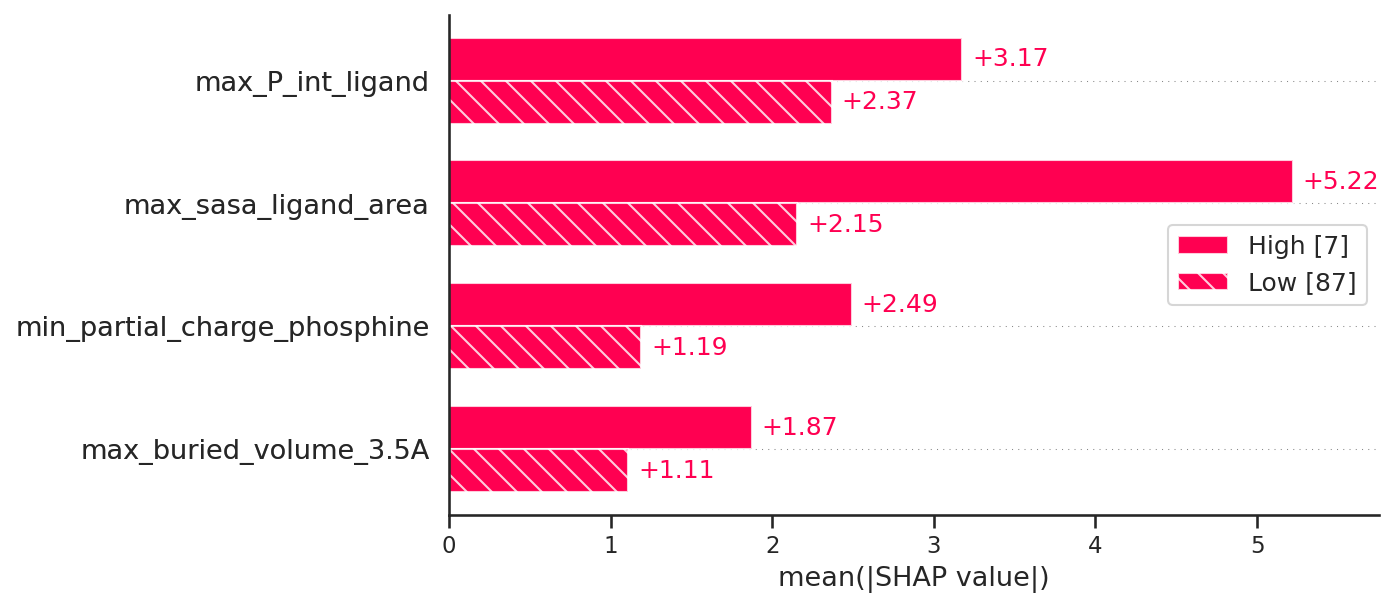

In [32]:
import shap

clf.fit(X, y_bin)
explainer = shap.explainers.LinearExplainer(clf.sk_model_, X)
shap_values = explainer(X)
for i, c in enumerate(X.columns):
    shap_values.feature_names[i] = c
shap_values.data = X.values


shap.plots.bar(shap_values.cohorts(np.array(y_bin)), max_display=10)

Text(0.5, 1.0, 'Global Feature Importance')

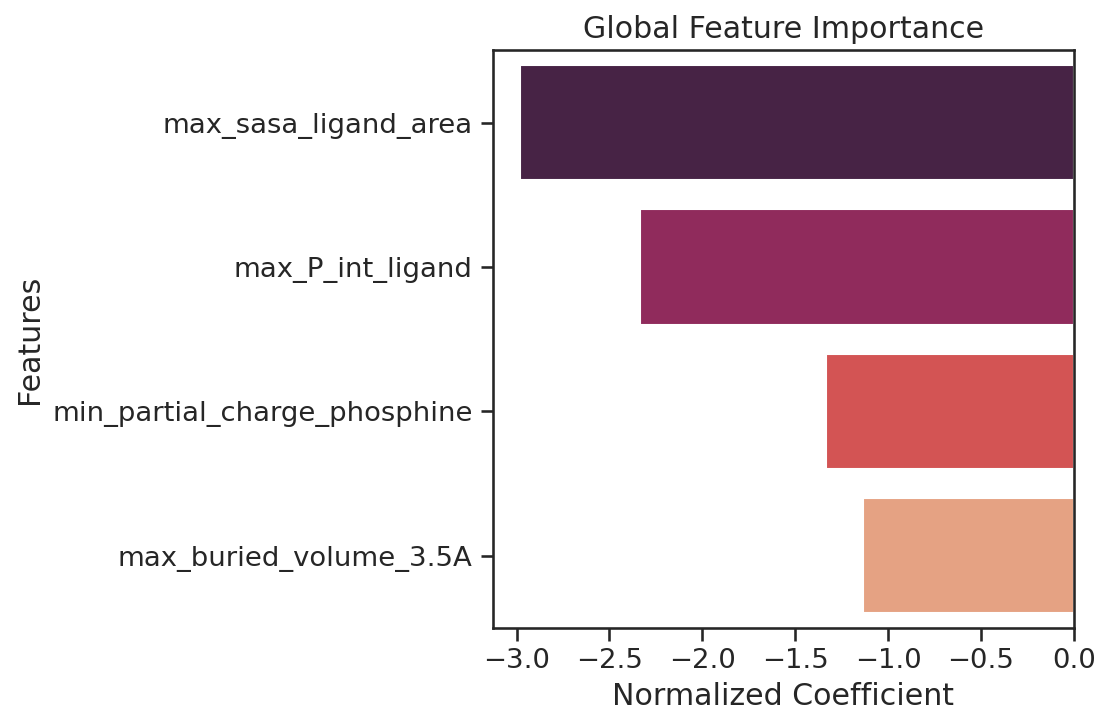

In [11]:
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2)

ax = sns.barplot(
    x=[c[1] for c in coefficients],
    y=[c[0] for c in coefficients],
    palette="rocket",
    hue=[c[0] for c in coefficients],
    legend=False,
)
ax.set_xlabel("Normalized Coefficient")
ax.set_ylabel("Features")
ax.set_title("Global Feature Importance")

In [7]:
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2)


def plot_local_importance(ligand):
    idx = df[df["ligand_1_name"] == ligand].index[0]

    row = df[df["ligand_1_name"] == ligand]
    name = row["ligand_1_name"].values[0]
    product_yield = row["product_1_yield"].values[0]
    prediction = clf.predict(X.iloc[idx].values.reshape(1, -1))[0]
    uncertainty = clf.predict_proba(X.iloc[idx].values.reshape(1, -1))[0]
    uncertainty = max(uncertainty) - min(uncertainty)

    X_indiv = X.iloc[idx].values.reshape(1, -1)
    y_bin_indiv = y_bin.iloc[idx]

    data = clf.explain_local(X_indiv, y_bin_indiv, name=df["ligand_1_name"].values).data(-1)["specific"]
    results = list(
        zip(
            data[0]["names"],
            data[0]["scores"],
            data[0]["values"],
        )
    )
    results = pd.DataFrame(results, columns=["Feature", "Contribution", "Value"])
    feature_sort = [
        "max_sasa_ligand_area",
        "max_P_int_ligand",
        "min_partial_charge_phosphine",
        "max_buried_volume_3.5A",
    ]
    results = results.set_index("Feature").reindex(feature_sort).reset_index()

    results["Feature"] = results.apply(lambda row: f"{row['Feature']} ({row['Value']:.2f})", axis=1)

    ax = sns.barplot(
        x="Contribution",
        y="Feature",
        data=results,
        palette="rocket",
        hue="Feature",
        legend=False,
        dodge=False,
    )
    ax.set_title(
        f"Ligand: {name}\nYield: {product_yield}, Pred: {prediction}, True: {["High" if product_yield > activity_cutoff else "Low"][0]}\nConfidence: {uncertainty * 100:0.0f}%"
    )
    ax.set_xlabel("Normalized Contribution")

    ax.set_xlim(-7, 7)

    ax.axvline(0, color="grey", linewidth=1, linestyle="--")

In [8]:
plot_local_importance("L-147")

ValueError: There are 4 features, but X has 9 columns

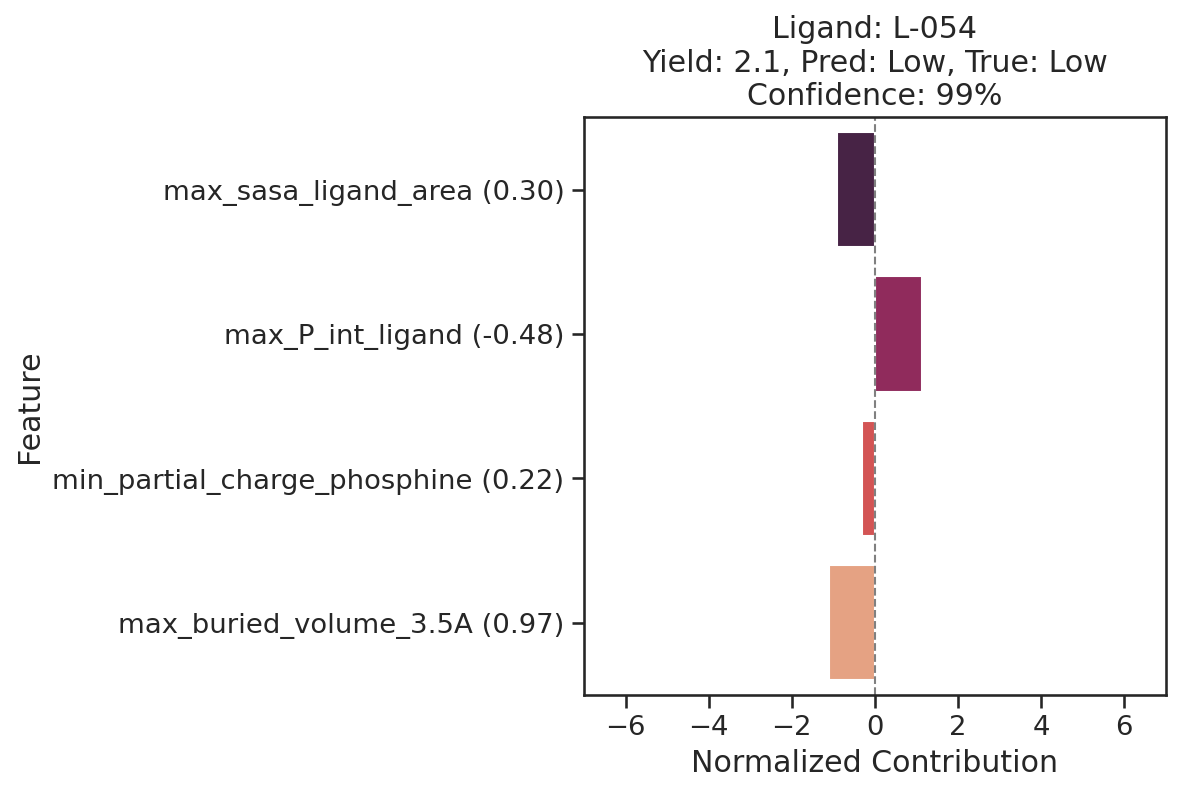

In [ ]:
plot_local_importance("L-054")

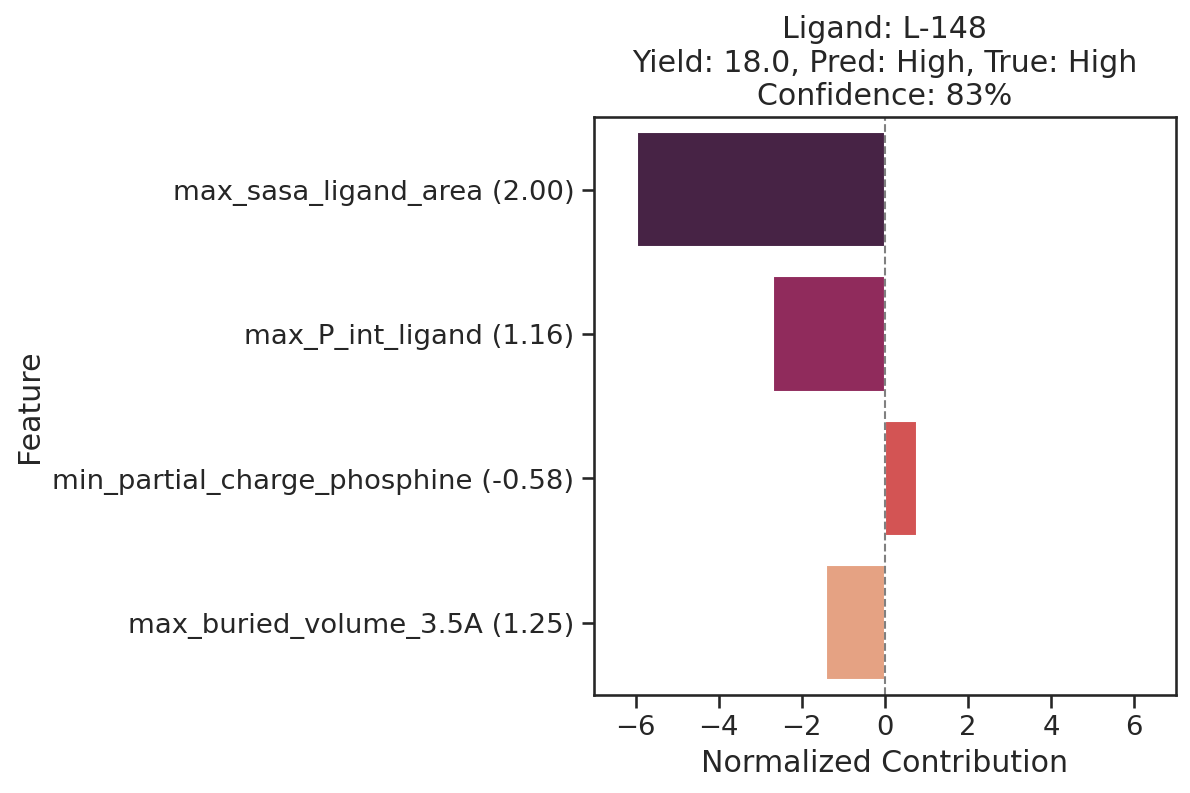

In [ ]:
plot_local_importance("L-148")

PCA explained variance ratio: [0.54901062 0.20767533]


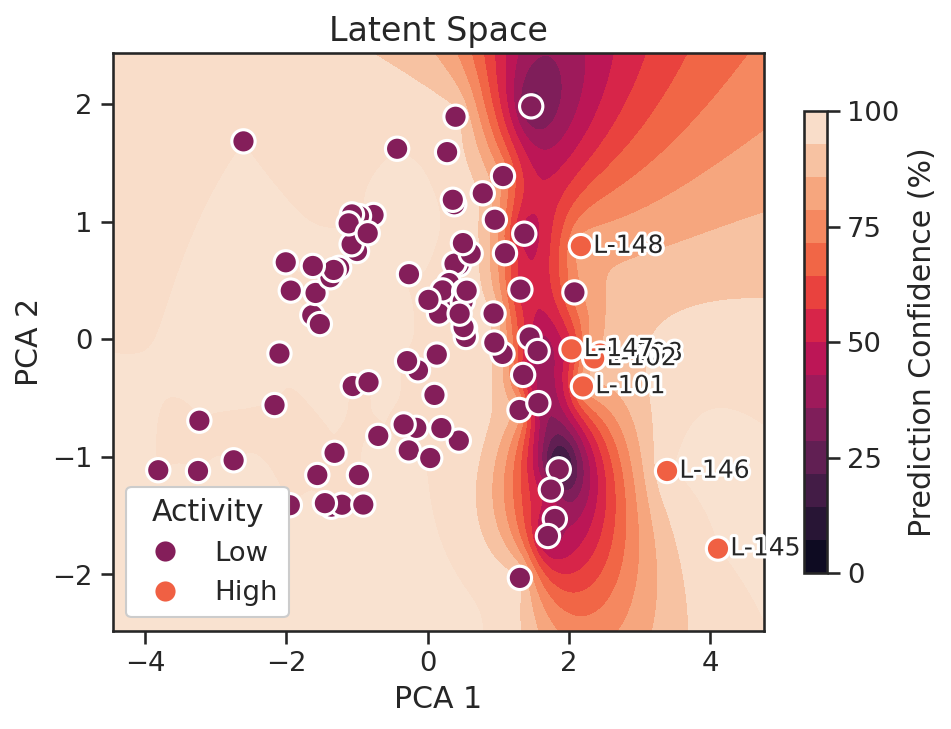

In [ ]:
import matplotlib.patheffects as pe
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.interpolate import RBFInterpolator
from sklearn.decomposition import PCA

sns.set_theme(rc={"figure.figsize": (7, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print("PCA explained variance ratio:", pca.explained_variance_ratio_)
components = pd.DataFrame(pca.components_, columns=features, index=["PCA 1", "PCA 2"])

ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], alpha=0)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

padding = 0.25
xmin, xmax = xmin - padding, xmax + padding
ymin, ymax = ymin - padding, ymax + padding

confidence = [max(p) - min(p) for p in clf.predict_proba(X)]
rbfi = RBFInterpolator(X_pca, confidence, kernel="linear")
x_grid, y_grid = np.meshgrid(
    np.linspace(xmin, xmax, 500),
    np.linspace(ymin, ymax, 500),
)
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
confidence_interp = rbfi(grid_points).reshape(x_grid.shape)

levels = np.linspace(0.0, 1.0, 15)
contour = ax.contourf(
    x_grid,
    y_grid,
    confidence_interp,
    cmap="rocket",
    levels=levels,
)

ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_bin, s=125, alpha=1.0, palette="rocket", linewidth=1.5)
ax.legend(title="Activity", loc="lower left", frameon=True, framealpha=1.0)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("Latent Space", fontsize=16)

colorbar = plt.colorbar(contour, shrink=0.8, label="Prediction Confidence (%)")
ticks = np.linspace(0, 1, 5)
colorbar.set_ticks(ticks)
ticklabels = [f"{t*100:0.0f}" for t in colorbar.get_ticks()]
colorbar.set_ticklabels(ticklabels)

ax.set_facecolor("#F9E2D0")

for i, txt in enumerate(df["ligand_1_name"]):
    if y_bin.iloc[i] == "High":
        ax.annotate(
            txt,
            (X_pca[i, 0] + 0.175, X_pca[i, 1] - 0.1),
            fontsize=12,
            ha="left",
            va="bottom",
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        )


In [ ]:
components.T.sort_values("PCA 1", ascending=False)

,PCA 1,PCA 2
max_sasa_ligand_area,0.618361,0.210330
max_P_int_ligand,0.529161,0.598232
max_buried_volume_3.5A,0.437620,-0.523629
min_partial_charge_phosphine,0.382238,-0.568940


In [ ]:
components.T.sort_values("PCA 2", ascending=False)

,PCA 1,PCA 2
max_P_int_ligand,0.529161,0.598232
max_sasa_ligand_area,0.618361,0.210330
max_buried_volume_3.5A,0.437620,-0.523629
min_partial_charge_phosphine,0.382238,-0.568940
